In [524]:
import os
import fnmatch
import yaml as yaml
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
import parse
import matplotlib.pyplot as plt
%matplotlib inline

In [525]:
def load_dataset_solar(dataset_name):
        
        path: Path =  Path("./dataset_solar/") / f"{dataset_name}.txt"
        #(
        ##    Path(__file__).parent
        #    / f"./dataset/{dataset_name}.txt"
        #)
        
        if not path.is_file():
            raise ValueError(f"Expected file with solar data in path {path}.")
        
        data: pd.DataFrame = pd.read_csv(
                                    path,
                                    sep = ',',
                                    skiprows=11, index_col = False)
        data.columns = ["date", "current_mA"]
        
        
        with open(path, "r") as f:
            for _ in range(2):
                line = f.readline()
            number_of_days = parse.search("Days: {:d}", line)[0] 
        
        # In Return: We skip the first day values here "data["current_mA"][288:].reset_index()"
        # since this is how it is done in C++ code by Lars

        return data["current_mA"][288:].reset_index(drop=True), number_of_days

In [526]:
def load_dataset_persons(dataset_name, config):
        
        path: Path = Path("./dataset_ski_images/ground_full_images_detections/") / f"{dataset_name}_cleaned.csv"
           # Path(__file__).parent
           # / f"./dataset_ski_images/ground_full_images_detections/{dataset_name}_cleaned.csv"
        #)
        
        if not path.is_file():
            raise ValueError(f"Expected file with ski data in path {path}.")
        
        get_columns = ['timestamp', 'filename', 'person_count', 'error_image', 'detections']
        data: pd.DataFrame = pd.read_csv(
                                    path,
                                    sep = ',',
                                    parse_dates=['timestamp'],
                                    #skiprows=11,
                                    usecols=get_columns)
        #data.columns = ["timestamp", "person_count"]
        start_date = config["start_day"]
        #duration: timedelta = timedelta(days=days)  #Make sure it's same in the configuration as well.
        #end_date = pd.to_datetime(start_date) + pd.DateOffset(days=config["days"])  # type: ignore
        #end_date = '2022-03-11'
        #data = data[(data['timestamp'] >= start_date) & (data['timestamp'] <= end_date)]
        data = data.rename(columns={ "filename":"image_filename", "person_count": "person_count_ground", "detections":"detections_ground"})
        
        # Filter error dates
        error_images_df = data[data.error_image == True]
        # Count error images and get only where instances of error is more than 10. Each day has 144 instances of recored.
        error_count = error_images_df["timestamp"].dt.normalize().value_counts().loc[lambda x : x > 10]
        error_dates = error_count.index.date

        # First resample to 5 seconds
        data = data.resample('5T', on='timestamp').first()
        data.reset_index(inplace=True)
        # Remove these dates
        data_clean = data[~data['timestamp'].dt.date.isin(error_dates)]
        
        data_clean = data_clean[(data_clean['timestamp'] >= start_date)]
        # Get unique dates to later select first N days
        unique_dates = data_clean['timestamp'].dt.date.unique()
        selected_dates = unique_dates[:config["days"]]
        selected_df = data_clean[data_clean['timestamp'].dt.date.isin(selected_dates)]
        #selected_df = selected_df.append(nextday_record)
        # We do this to merge later with main df
        #data.set_index("timestamp", inplace=True, drop=True)

        return selected_df.reset_index()    

## Set Configuration

In [527]:
dataset_solar_name = "TUHHx"
dataset_camera_name = "skistua" #Available Cameras: ['jervskogen_1', 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua']
days = 80
total_rows = 288 * days
shift_value = 9
normalization = False

configuration  = {
            "start_day" : "2021-12-11",
            "days": days,
            "solar_scale": 1
        }


### Load Solar dataset

<AxesSubplot: >

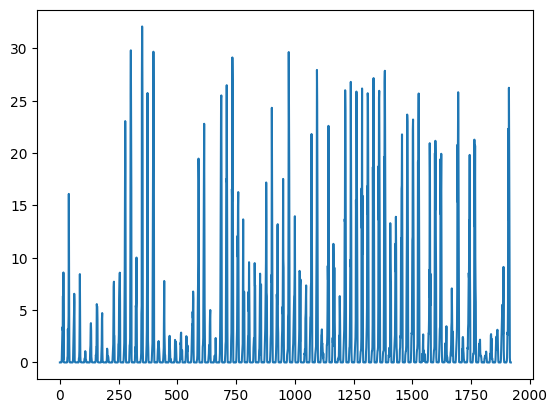

In [528]:
solar_data,  number_of_days = load_dataset_solar(dataset_solar_name)
#print(solar_data)

solar_df: pd.DataFrame = pd.DataFrame()
solar_df["current_mA"] =  solar_data * configuration["solar_scale"] 

# Reset the index of solar_df
solar_df.reset_index(drop=True, inplace=True)

# Print solar_df to verify data
#print(solar_df)
solar_df = solar_df["current_mA"][:total_rows]
solar_averaged_df = solar_df.groupby(solar_df.index // 12).mean(numeric_only=True)

# Print solar_averaged_df to verify the result
#print(solar_averaged_df)
solar_averaged_df.plot()

### Load Person dataset

<AxesSubplot: >

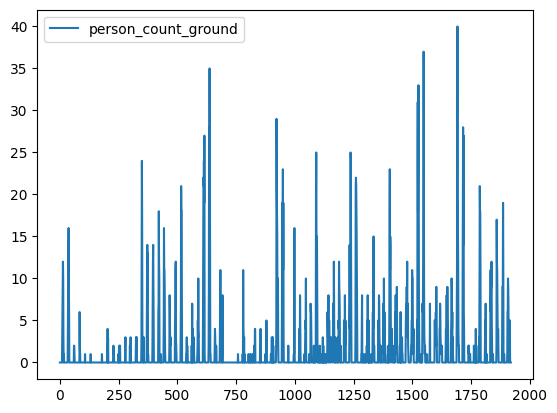

In [529]:
person_df = load_dataset_persons(dataset_camera_name, configuration)
# Drop all columns except 'person_count_ground' and 'timestamp'
df_filtered = person_df[['person_count_ground']]


# Reset the index of 
df_filtered.reset_index(drop=True, inplace=True)

#print(df_filtered)
person_averaged_df = df_filtered.groupby(df_filtered.index // 12).sum(numeric_only=True)

# Print person_averaged_df to verify the result
person_averaged_df.plot()

### Shift Person Count data

<AxesSubplot: >

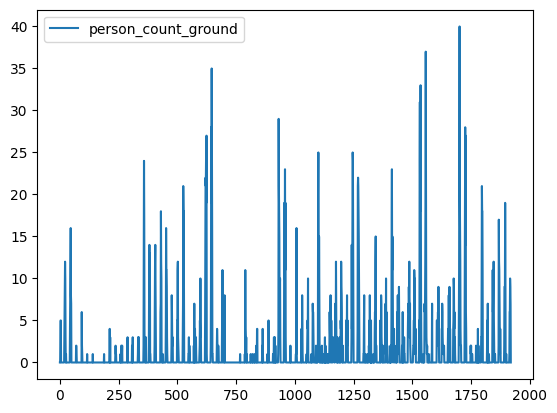

In [530]:
# Perform cyclic shift by 12 positions
shifted_values = np.roll(person_averaged_df['person_count_ground'], shift_value)

# Update the 'person_count_ground' column with the shifted values
person_averaged_df['person_count_ground'] = shifted_values
shifted_person_df = person_averaged_df
shifted_person_df.plot()

### Create Scatter Plot

Alignment Percentage (Cosine Similarity): 1.28%
Alignment Percentage (Correlation Coefficient): 16.94%
Alignment Percentage (Manhattan Distance): 2.22%


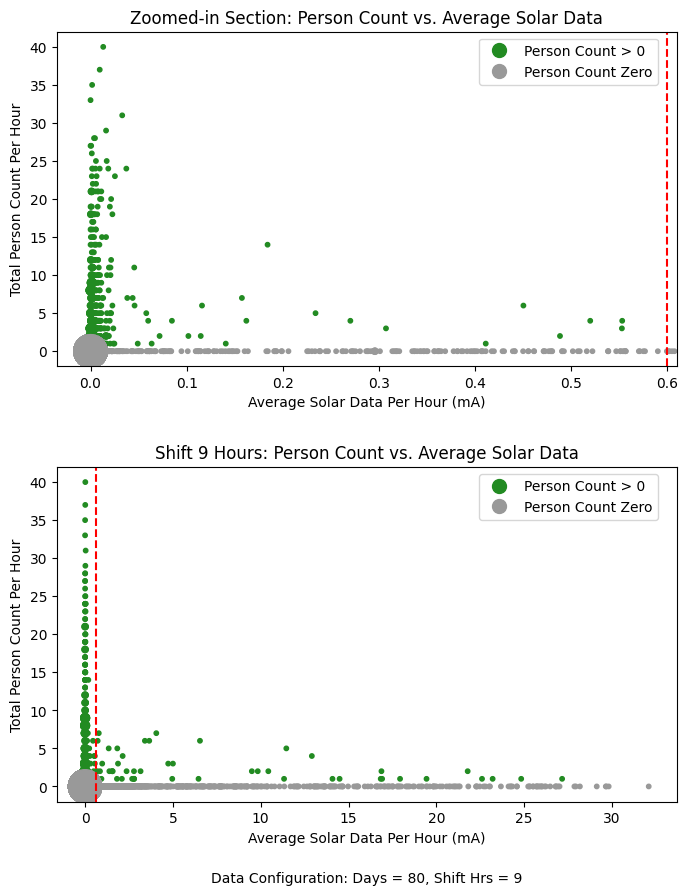

In [531]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

shifted = shift_value
x_axis_data = solar_averaged_df.values
y_axis_data = shifted_person_df["person_count_ground"]


if normalization == True:

    # Assuming you have two DataFrames: df_x and df_y

    # Perform min-max normalization using sklearn's MinMaxScaler
    scaler = MinMaxScaler()
    x_normalized = scaler.fit_transform(solar_averaged_df.values.reshape(-1, 1)).flatten()
    y_normalized = scaler.fit_transform(shifted_person_df.values.reshape(-1, 1)).flatten()

    x_axis_data = x_normalized
    y_axis_data = y_normalized


# Calculate the count of each data point
counts = {}
for i in range(len(x_axis_data)):
    if (x_axis_data[i], y_axis_data[i]) in counts:
        counts[(x_axis_data[i], y_axis_data[i])] += 1
    else:
        counts[(x_axis_data[i], y_axis_data[i])] = 1

# Set the size of the markers based on the counts
sizes = [counts[(x_axis_data[i], y_axis_data[i])] * 10 for i in range(len(x_axis_data))]

# Convert the vectors to numpy arrays
array1 = np.array(x_axis_data).reshape(1, -1)
array2 = np.array(y_axis_data).reshape(1, -1)

# Calculate the cosine similarity
cos_sim = cosine_similarity(array1, array2)

# Calculate the correlation coefficient
corr_coef = np.corrcoef(array1.ravel(), array2.ravel())[0, 1]

# Calculate the Euclidean distance
#euclidean_dist = np.linalg.norm(array1 - array2)

# Calculate the Manhattan distance
manhattan_dist = distance.cityblock(array1.ravel(), array2.ravel())


# Calculate the alignment percentages
cosine_alignment = cos_sim[0, 0] * 100
correlation_alignment = abs(corr_coef) * 100
#euclidean_alignment = (1 - euclidean_dist / np.sqrt(np.sum(array1**2) + np.sum(array2**2))) * 100
manhattan_alignment = (1 - manhattan_dist / np.sum(np.abs(array1) + np.abs(array2))) * 100

# Print the alignment percentages
print(f"Alignment Percentage (Cosine Similarity): {cosine_alignment:.2f}%")
print(f"Alignment Percentage (Correlation Coefficient): {correlation_alignment:.2f}%")
#print(f"Alignment Percentage (Euclidean Distance): {euclidean_alignment:.2f}%")
print(f"Alignment Percentage (Manhattan Distance): {manhattan_alignment:.2f}%")


# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot 1: Zoomed-in section
ax1.scatter(x=x_axis_data, y=y_axis_data, s=sizes, c=np.where(y_axis_data == 0, '#999999', '#228B22'))
ax1.axvline(x=0.6, color='red', linestyle='--')
ax1.set_xlim(min(x_axis_data)-0.035, 0.6+0.01)
ax1.set_xlabel('Average Solar Data Per Hour (mA)')
ax1.set_ylabel('Total Person Count Per Hour')
ax1.set_title('Zoomed-in Section: Person Count vs. Average Solar Data')

# Plot 2: Original plot
scatter2 = ax2.scatter(x=x_axis_data, y=y_axis_data, s=sizes,c=np.where(y_axis_data == 0, '#999999', '#228B22'))
ax2.axvline(x=0.6, color='red', linestyle='--')
ax2.set_xlabel('Average Solar Data Per Hour (mA)')
ax2.set_ylabel('Total Person Count Per Hour')
ax2.set_title('Shift {} Hours: Person Count vs. Average Solar Data'.format(shifted))

# Create custom legend for the green circles
green_patch = plt.Line2D([], [], marker='o', markersize=10, color='#999999', linestyle='None', label='Person Count Zero')
default_patch = plt.Line2D([], [], marker='o', markersize=10, color='#228B22', linestyle='None', label='Person Count > 0')
ax1.legend(handles=[default_patch, green_patch ], loc='upper right', bbox_to_anchor=(0.98, 1))
ax2.legend(handles=[default_patch, green_patch ], loc='upper right', bbox_to_anchor=(0.98, 1))

# Add text in two lines at the end of the plots
ax2.text(0.5, -0.24, 'Data Configuration: Days = ' + str(days) + ', Shift Hrs = ' + str(shift_value)  , transform=ax2.transAxes, ha='center')


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()